# ENGG3130 Case Study: Autonomous Drone Simulations using Boids

By: Kobe Barette, Liam Holt, Klaire McCarthy, and Thomas Zupan

Base Boid class is from [Think Complexity, 2nd edition](https://thinkcomplex.com) and the Boids7nb.ipynd notebook.

Note that vpython will not run on Python 3.13.

Note: If the simulation animations do not appear in the notebook, restart your environment and they should appear.

In [1]:
try:
    from vpython import *
except:
    print("This program requires VPython 7, which you can read about")
    print("at http://vpython.org/.  If you are using Anaconda, you can")
    print("install VPython by running the following on the command line:")
    print("conda install -c vpython vpython")
    raise ImportError


import numpy as np
from time import time
import random
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

First, we must define the simulation space and replicate a search and rescue scenario:

The draw_wireframe_box function defines a visual simulation space.

In [2]:
def draw_wireframe_box(center, size, col=color.black):
    width = size
    depth = size
    height = size

    sx, sy, sz = width / 2, height / 2, depth / 2
    corners = [vector(x, y, z) for x in (-sx, sx) for y in (-sy, sy) for z in (-sz, sz)]

    edges = [(0, 1), (0, 2), (0, 4), (1, 3),
             (1, 5), (2, 3), (2, 6), (3, 7),
             (4, 5), (4, 6), (5, 7), (6, 7)]

    for i, j in edges:
        curve(pos=[center + corners[i], center + corners[j]], color=col, radius=0.02)  # thinner lines

    # Code to setup the grass space
    ground_resolution = 20
    tile_w = width / ground_resolution
    tile_d = depth / ground_resolution
    ground_y = center.y - height / 2 - 0.05

    for i in range(ground_resolution):
        for j in range(ground_resolution):
            gx = -sx + (i + 0.5) * tile_w
            gz = -sz + (j + 0.5) * tile_d
            box(pos=vector(center.x + gx, ground_y, center.z + gz),
                size=vector(tile_w, 0.02, tile_d),
                color=color.green)

    # Add trees
    num_trees = 30
    for _ in range(num_trees):
        gx = random.uniform(-sx + 0.5, sx - 0.5)
        gz = random.uniform(-sz + 0.5, sz - 0.5)
        gy = ground_y

        trunk_height = random.uniform(0.2, 0.3)
        cylinder(pos=vector(center.x + gx, gy, center.z + gz),
                 axis=vector(0, trunk_height, 0),
                 radius=0.03,
                 color=vector(0.55, 0.27, 0.07))  # brown trunk

        sphere(pos=vector(center.x + gx, gy + trunk_height + 0.05, center.z + gz),
               radius=trunk_height * 0.4,
               color=color.green)

    # Add a semi-transparent light blue top face
    face_color = vector(0.5, 0.8, 1.0)  # light blue
    face_opacity = 0.2  # semi-transparent
    face_indices = {
        'top':    [1, 3, 7, 5],  # y = +sy
        'bottom': [0, 2, 6, 4],  # y = -sy
        'right':  [4, 5, 7, 6],  # x = +sx
        'back':   [0, 4, 5, 1],  # z = -sz
        'front':  [2, 6, 7, 3] 
        # [0, 1, 3, 2]
    }

    for face in face_indices.values():
        quad(
            v0=vertex(pos=center + corners[face[0]], color=face_color, opacity=face_opacity),
            v1=vertex(pos=center + corners[face[1]], color=face_color, opacity=face_opacity),
            v2=vertex(pos=center + corners[face[2]], color=face_color, opacity=face_opacity),
            v3=vertex(pos=center + corners[face[3]], color=face_color, opacity=face_opacity)
        )



In [3]:
null_vector = vector(0,0,0)


def random_vector(a, b):
    """Create a vector with each element uniformly distributed in [a, b)."""
    coords = np.random.uniform(a, b, size=3)
    return vector(*coords)


def limit_vector(vect):
    """If the magnitude is greater than 1, set it to 1"""
    if vect.mag > 1:
        vect.mag = 1
    return vect

The Boid class:

In [4]:
class Boid(cone):
    """A Boid is a VPython cone with a velocity and an axis."""

    def __init__(self, radius=0.03, length=0.1):
        corner = vector(-size, -size, -size)
        jitter = np.random.uniform(0, 0.1, size=3)  # Small offset so they’re not overlapping
        pos = corner + vector(*jitter)
        self.vel = random_vector(0, 1).norm()
        cone.__init__(self, pos=pos, radius=radius, length=length, color=color.blue)
        self.axis = length * self.vel

    def get_neighbors(self, boids, radius, angle):
        """Return a list of neighbors within a field of view.

        boids: list of boids
        radius: field of view radius
        angle: field of view angle in radians

        returns: list of Boid
        """
        neighbors = []
        for boid in boids:
            if boid is self:
                continue
            offset = boid.pos - self.pos

            # if not in range, skip it
            if offset.mag > radius:
                continue

            # if not within viewing angle, skip it
            diff = self.vel.diff_angle(offset)
            if abs(diff) > angle:
                continue

            # otherwise add it to the list
            neighbors.append(boid)

        return neighbors

    def center(self, boids, radius=1, angle=1):
        """Find the center of mass of other boids in range and
        return a vector pointing toward it."""
        neighbors = self.get_neighbors(boids, radius, angle)
        vecs = [boid.pos for boid in neighbors]
        return self.vector_toward_center(vecs)

    def vector_toward_center(self, vecs):
        """Vector from self to the mean of vecs.

        vecs: sequence of vector

        returns: Vector
        """
        if vecs:
            center = np.mean(vecs)
            toward = vector(center - self.pos)
            return limit_vector(toward)
        else:
            return null_vector

    def avoid(self, boids, carrot, radius=0.3, angle=np.pi):
        """Find the center of mass of all objects in range and
        return a vector in the opposite direction, with magnitude
        proportional to the inverse of the distance (up to a limit)."""
        objects = boids + [carrot]
        neighbors = self.get_neighbors(objects, radius, angle)
        vecs = [boid.pos for boid in neighbors]
        return -self.vector_toward_center(vecs)

    def align(self, boids, radius=0.5, angle=1):
        """Return the average heading of other boids in range.

        boids: list of Boids
        """
        neighbors = self.get_neighbors(boids, radius, angle)
        vecs = [boid.vel for boid in neighbors]
        return self.vector_toward_center(vecs)

    def love(self, carrot):
        """Returns a vector pointing toward the carrot."""
        toward = carrot.pos - self.pos
        return limit_vector(toward)

    def set_goal(self, boids, carrot):
        """Sets the goal to be the weighted sum of the goal vectors."""

        # weights for various rules
        w_avoid = 10
        w_center = 3
        w_align = 1
        w_love = 10

        self.goal = (w_center * self.center(boids) +
                     w_avoid * self.avoid(boids, carrot) +
                     w_align * self.align(boids) +
                     w_love * self.love(carrot))
        self.goal.mag = 1

    def move(self, mu=0.1, dt=0.1, bounds=3):
        """Update the velocity, position and axis vectors.

        mu: how fast the boids can turn (maneuverability).
        dt: time step
        """

        self.vel = (1-mu) * self.vel + mu * self.goal
        self.vel.mag = 1
        self.pos += dt * self.vel
        self.axis = self.length * self.vel
        # Bounce off the walls (in x, y, z directions)
        for axis in ['x', 'y', 'z']:
            if abs(getattr(self.pos, axis)) > bounds:
                # Invert velocity on that axis
                setattr(self.vel, axis, -getattr(self.vel, axis))
                # Move the boid back inside the bounds
                setattr(self.pos, axis, np.sign(getattr(self.pos, axis)) * bounds)


class World(object):

    def __init__(self, n=10):
        """Create n Boids and one carrot.

        tracking: indicates whether the carrot follows the mouse
        """
        self.boids = [Boid() for i in range(n)]
        self.carrot = sphere(pos=vector(1,0,0),
                             radius=0.1,
                             color=vector(1,0,0))
        self.tracking = False
        draw_wireframe_box(center=vector(0,0,0), size=2*size)

    def step(self):
        """Compute one time step."""
        # move the boids
        for boid in self.boids:
            boid.set_goal(self.boids, self.carrot)
            boid.move(bounds=size)

        # if we're tracking, move the carrot
        if self.tracking:
            self.carrot.pos = scene.mouse.pos

The first simulation: one package placed in the center of the simulation space. We will measure the time it takes to reach the package.

In [5]:
n = 20
size = 5
scene = canvas()
scene.background = color.white
scene.title = "First Simulation - Package placed in center"
world = World(n)
scene.center = world.carrot.pos
scene.autoscale = False

def toggle_tracking(evt):
    """If we're currently tracking, turn it off, and vice versa.
    """
    world.tracking = not world.tracking

# when the user clicks, toggle tracking.
scene.bind('click', toggle_tracking)

# Simulation start
start_time = time()

while 1:
    rate(10)
    world.step()

    # Check if any boid reached the carrot
    for boid in world.boids:
        if mag(boid.pos - world.carrot.pos) < 0.2:
            end_time = time()
            duration = end_time - start_time
            print(f"Goal reached in {duration:.2f} seconds!")
            break
    else:
        continue  # Continue the while loop if no boid reached
    break  # Break the while loop if a boid did reach

<IPython.core.display.Javascript object>

Goal reached in 9.11 seconds!


Second simulation: The package will be placed in a random location.

In [6]:
# Create a new canvas to avoid drawing over the old one
scene2 = canvas()
scene2.background = color.white
scene2.title = "Second Simulation - Package randomly placed in workspace"

# Define a random position within the wireframe boundaries
def random_carrot_position(bound):
    margin = 0.5  # avoid putting carrot right at the edge
    return vector(
        random.uniform(-bound + margin, bound - margin),
        random.uniform(-bound + margin, bound - margin),
        random.uniform(-bound + margin, bound - margin)
    )

# Create a new world and assign a random carrot position
world2 = World(n)
world2.carrot.pos = random_carrot_position(size)

# Set the scene center to the center of the world, not the carrot
scene2.center = vector(0, 0, 0)  # center of wireframe
scene2.autoscale = False

# Optional: track the carrot on click
def toggle_tracking_2(evt):
    world2.tracking = not world2.tracking

scene2.bind('click', toggle_tracking_2)

# Run the second simulation
start_time = time()

while True:
    rate(10)
    world2.step()

    for boid in world2.boids:
        if mag(boid.pos - world2.carrot.pos) < 0.2:
            duration = time() - start_time
            print(f"[Second Simulation] Goal reached in {duration:.2f} seconds!")
            break
    else:
        continue
    break



<IPython.core.display.Javascript object>

[Second Simulation] Goal reached in 7.49 seconds!


Now, we will add a second carrot into the simulation space.

To do this we must create a new boid class that inherits from the original but can locate two packages.

In [7]:
class TwoCarrotBoid(Boid):
    def avoid(self, boids, carrot, radius=0.3, angle=np.pi):
        """Original avoid behavior without obstacles"""
        objects = boids + [carrot]
        neighbors = self.get_neighbors(objects, radius, angle)
        vecs = [obj.pos for obj in neighbors]
        return -self.vector_toward_center(vecs)
    
    def set_goal(self, boids, carrot):
        """Original goal setting without obstacles"""
        w_avoid = 10
        w_center = 3
        w_align = 1
        w_love = 10
        
        self.goal = (w_center * self.center(boids) +
                     w_avoid * self.avoid(boids, carrot) +
                     w_align * self.align(boids) +
                     w_love * self.love(carrot))
        self.goal.mag = 1

Next, we must also modify the world class to have a second carrot that is not too close to the first carrot.

In [8]:
class TwoCarrotWorld(World):
    def __init__(self, n=10):
        self.boids = [TwoCarrotBoid() for _ in range(n)]
        # Create two carrots
        # First carrot
        self.carrot1 = sphere(pos=random_vector(-size+1, size-1),
                              radius=0.1, color=vector(1,0,0))
        
        # Second carrot - ensure minimum distance from first carrot
        min_distance = 2  # Minimum distance between carrots
        while True:
            self.carrot2 = sphere(pos=random_vector(-size+1, size-1),
                                  radius=0.1, color=vector(0.5,0,0.5))
            if mag(self.carrot1.pos - self.carrot2.pos) >= min_distance:
                break
        self.current_carrot = self.carrot1
        draw_wireframe_box(center=vector(0,0,0), size=2*size)
        self.tracking = False

    def step(self):
        """Modified step for two carrots"""
        for boid in self.boids:
            boid.set_goal(self.boids, self.current_carrot)
            boid.move(bounds=size)

Our next simulation will test having two carrots in the simulation space.

In [9]:
n = 20
size = 5
scene = canvas()
scene.background = color.white
world = TwoCarrotWorld(n)
scene.center = vector(0,0,0)
scene.autoscale = False

def toggle_tracking(evt):
    world.tracking = not world.tracking

scene.bind('click', toggle_tracking)

start_time = time()
first_leg_done = False
second_leg_done = False

while True:
    rate(10)
    world.step()
    
    # Check carrot progression
    for boid in world.boids:
        if not first_leg_done and mag(boid.pos - world.carrot1.pos) < 0.2:
            print(f"First carrot reached in {time()-start_time:.2f}s")
            world.current_carrot = world.carrot2
            first_leg_done = True
            break
        elif first_leg_done and not second_leg_done and mag(boid.pos - world.carrot2.pos) < 0.2:
            print(f"Second carrot reached in {time()-start_time:.2f}s")
            second_leg_done = True
            break
    
    if second_leg_done:
        break

<IPython.core.display.Javascript object>

First carrot reached in 3.04s
Second carrot reached in 12.55s


For the next simulation, we will modify the boid class to be able to avoid an obstacle placed in the simulation space, consider the obstacles in avoidance, and manouver around the obstacles. 

In [10]:
class NewBoid(Boid):
    def avoid(self, boids, carrot, obstacles=None, radius=0.3, angle=np.pi):
        """Avoid obstacles and other boids."""
        objects = boids + [carrot]
        if obstacles:
            objects.extend(obstacles)
        neighbors = self.get_neighbors(objects, radius, angle)
        vecs = [obj.pos for obj in neighbors]
        return -self.vector_toward_center(vecs)
    
    def set_goal(self, boids, carrot, obstacles=None):
        """Set goal considering obstacles."""
        w_avoid = 10
        w_center = 3
        w_align = 1
        w_love = 10
        
        self.goal = (w_center * self.center(boids) +
                     w_avoid * self.avoid(boids, carrot, obstacles) +
                     w_align * self.align(boids) +
                     w_love * self.love(carrot))
        self.goal.mag = 1
    
    def move(self, mu=0.1, dt=0.1, bounds=3, obstacles=None):
        """Handle movement with obstacle collision."""
        super().move(mu, dt, bounds)
        if obstacles:
            for obstacle in obstacles:
                obs_min = obstacle.pos - obstacle.size/2
                obs_max = obstacle.pos + obstacle.size/2
                inside = all(getattr(self.pos, axis) > getattr(obs_min, axis) and
                             getattr(self.pos, axis) < getattr(obs_max, axis)
                             for axis in ['x', 'y', 'z'])
                if inside:
                    escape_dirs = {}
                    for axis in ['x', 'y', 'z']:
                        dist_to_min = abs(getattr(self.pos, axis) - getattr(obs_min, axis))
                        dist_to_max = abs(getattr(obs_max, axis) - getattr(self.pos, axis))
                        escape_dirs[axis] = min(dist_to_min, dist_to_max)
                    exit_axis = min(escape_dirs, key=escape_dirs.get)
                    setattr(self.vel, exit_axis, -getattr(self.vel, exit_axis))
                    if getattr(self.pos, exit_axis) < getattr(obstacle.pos, exit_axis):
                        setattr(self.pos, exit_axis, getattr(obs_min, exit_axis) - 0.01)
                    else:
                        setattr(self.pos, exit_axis, getattr(obs_max, exit_axis) + 0.01)

We must also modify the world class to be able to handle multiple packages and obstacles.

In [11]:
# Define NewWorld subclassing World to handle two carrots and obstacles
class NewWorld(World):
    def __init__(self, n=10):
        self.boids = [NewBoid() for _ in range(n)]
        # First carrot
        self.carrot1 = sphere(pos=random_vector(-size+1, size-1),
                              radius=0.1, color=vector(1,0,0))
        
        # Second carrot - ensure minimum distance from first carrot
        min_distance = 2  # Minimum distance between carrots
        while True:
            self.carrot2 = sphere(pos=random_vector(-size+1, size-1),
                                  radius=0.1, color=vector(0.5,0,0.5))
            if mag(self.carrot1.pos - self.carrot2.pos) >= min_distance:
                break
        self.current_carrot = self.carrot1
        self.obstacles = []
        obstacle_count = 3
        obstacle_size = vector(2, 2, 2)
        
        while len(self.obstacles) < obstacle_count:
            rand_pos = random_vector(-size+1, size-1)
            too_close = False
            for carrot in [self.carrot1, self.carrot2]:
                if mag(rand_pos - carrot.pos) < 2:
                    too_close = True
                    break
            for obs in self.obstacles:
                if mag(rand_pos - obs.pos) < 2:
                    too_close = True
                    break
            if not too_close:
                obstacle = box(pos=rand_pos, size=obstacle_size, color=color.gray(0.5), opacity=0.4)
                self.obstacles.append(obstacle)
        draw_wireframe_box(center=vector(0,0,0), size=2*size)
        self.tracking = False
    
    def step(self):
        for boid in self.boids:
            boid.set_goal(self.boids, self.current_carrot, self.obstacles)
            boid.move(bounds=size, obstacles=self.obstacles)

Now we will simulate a scenario with two packages and three large obstacles in random locations and measure time. 

In [12]:
# Simulation setup
n = 20
size = 5
scene = canvas()
scene.background = color.white
world = NewWorld(n)
scene.center = vector(0,0,0)
scene.autoscale = False

def toggle_tracking(evt):
    world.tracking = not world.tracking

scene.bind('click', toggle_tracking)

start_time = time()
first_leg_done = False
second_leg_done = False

while True:
    rate(10)
    world.step()
    
    for boid in world.boids:
        if not first_leg_done and mag(boid.pos - world.carrot1.pos) < 0.2:
            print(f"Carrot 1 reached in {time()-start_time:.2f}s")
            world.current_carrot = world.carrot2
            first_leg_done = True
            break
        elif first_leg_done and not second_leg_done and mag(boid.pos - world.carrot2.pos) < 0.2:
            print(f"Carrot 2 reached in {time()-start_time:.2f}s")
            second_leg_done = True
            break
    
    if second_leg_done:
        break

<IPython.core.display.Javascript object>

Carrot 1 reached in 13.51s
Carrot 2 reached in 17.98s


Now we will create Boid2(), a class that can be used to create a second swarm of boids.

We will also modify the World class to be able to handle the second set of boids.

In [13]:
def random_pos():
    return vector(*np.random.uniform(-size, size, size=3))
    
class Boid2(NewBoid):
    """A second type of boid that starts from the opposite corner and is a different color."""

    def __init__(self, radius=0.03, length=0.1):
        # Start in bottom-back-right corner
        start_corner = vector(size - 0.5, -size + 0.5, size - 0.5)
        jitter = np.random.uniform(0, 0.5, size=3)
        pos = start_corner + vector(*jitter)
        self.vel = random_vector(0, 1).norm()
        # Use orange color for this swarm
        cone.__init__(self, pos=pos, radius=radius, length=length, color=color.orange)
        self.axis = length * self.vel
        
class World2(NewWorld):
    def __init__(self, n=10):
        self.boids1 = [NewBoid() for _ in range(n)]
        self.boids2 = [Boid2() for _ in range(n)]
        self.all_boids = self.boids1 + self.boids2

        self.carrot1a = sphere(pos=random_pos(), radius=0.1, color=vector(1, 0, 0))  # Red
        self.carrot2a = sphere(pos=random_pos(), radius=0.1, color=vector(0, 1, 0))  # Green

        self.carrot1b = self.carrot1a
        self.carrot2b = self.carrot2a

        # Independent goal tracking
        self.current_carrot1 = self.carrot1a  # For boids1
        self.current_carrot2 = self.carrot1b  # For boids2

        self.obstacles = []
        obstacle_count = 3
        obstacle_size = vector(2, 2, 2)

        # List of shape functions to randomly choose from
        obstacle_shapes = ['box', 'sphere', 'pyramid', 'cone', 'ellipsoid']

        while len(self.obstacles) < obstacle_count:
            rand_pos = vector(
                random.uniform(-size + 1, size - 1),
                random.uniform(-size + 1, size - 1),
                random.uniform(-size + 1, size - 1)
            )

            too_close = False
            for carrot in [self.carrot1a, self.carrot2a, self.carrot1b, self.carrot2b]:
                if mag(rand_pos - carrot.pos) < 2:
                    too_close = True
                    break
            for obs in self.obstacles:
                if mag(rand_pos - obs.pos) < 2:
                    too_close = True
                    break

            if not too_close:
                shape = random.choice(obstacle_shapes)
                if shape == 'box':
                    obstacle = box(pos=rand_pos, size=obstacle_size, color=color.gray(0.5), opacity=0.4)
                elif shape == 'sphere':
                    obstacle = sphere(pos=rand_pos, radius=obstacle_size.x / 2, color=color.cyan, opacity=0.4)
                elif shape == 'pyramid':
                    obstacle = pyramid(pos=rand_pos, size=obstacle_size, color=color.green, opacity=0.4)
                elif shape == 'cone':
                    obstacle = cone(pos=rand_pos, axis=vector(0, obstacle_size.y, 0), radius=obstacle_size.x / 2,
                                    color=color.orange, opacity=0.4)
                elif shape == 'ellipsoid':
                    obstacle = ellipsoid(pos=rand_pos, length=obstacle_size.z, height=obstacle_size.y,
                                         width=obstacle_size.x, color=color.purple, opacity=0.4)

                self.obstacles.append(obstacle)
        
        self.tracking = False
        draw_wireframe_box(center=vector(0, 0, 0), size=2 * size)

    def step(self):
        for boid in self.boids1:
            boid.set_goal(self.boids1, self.current_carrot1, self.obstacles)
            boid.move(bounds=size, obstacles=self.obstacles)

        for boid in self.boids2:
            boid.set_goal(self.boids2, self.current_carrot2, self.obstacles)
            boid.move(bounds=size, obstacles=self.obstacles)

Now lets simulate a scenario with two swarms of boids, two packages, and three obstacles.

In [14]:
n = 20
size = 5
scene = canvas()
scene.width = 500
scene.height = 500
scene.background = color.white

world = World2(n)
scene.center = vector(0, 0, 0)
scene.autoscale = False

def toggle_tracking(evt):
    world.tracking = not world.tracking

scene.bind('click', toggle_tracking)

# Timing flags
start_time = time()
first_leg_done1 = False
second_leg_done1 = False
first_leg_done2 = False
second_leg_done2 = False

# Separate timers for each swarm
time_data = {
    "boids1": {"carrot1": None, "carrot2": None},
    "boids2": {"carrot1": None, "carrot2": None}
}

# Main loop
while True:
    rate(10)
    world.step()

    for boid in world.boids1:
        if not first_leg_done1 and mag(boid.pos - world.carrot1a.pos) < 0.2:
            t = time()
            time_data["boids1"]["carrot1"] = t - start_time
            first_leg_done1 = True
            world.current_carrot1 = world.carrot2a  # Swarm 1 switches to 2nd carrot
            break
        elif first_leg_done1 and not second_leg_done1 and mag(boid.pos - world.carrot2a.pos) < 0.2:
            t = time()
            time_data["boids1"]["carrot2"] = t - start_time
            second_leg_done1 = True
            break

    for boid in world.boids2:
        if not first_leg_done2 and mag(boid.pos - world.carrot1b.pos) < 0.2:
            t = time()
            time_data["boids2"]["carrot1"] = t - start_time
            first_leg_done2 = True
            world.current_carrot2 = world.carrot2b  # Swarm 2 switches to 2nd carrot
            break
        elif first_leg_done2 and not second_leg_done2 and mag(boid.pos - world.carrot2b.pos) < 0.2:
            t = time()
            time_data["boids2"]["carrot2"] = t - start_time
            second_leg_done2 = True
            break

    if second_leg_done1 and second_leg_done2:
        break

# Final summary with comparison
print("\n--- Final Timing Summary ---")

for i, carrot_label in enumerate(["carrot1", "carrot2"], start=1):
    t1 = time_data["boids1"][carrot_label]
    t2 = time_data["boids2"][carrot_label]

    print(f"\nCarrot {i}:")
    print(f"  Swarm 1: {t1:.2f} seconds")
    print(f"  Swarm 2: {t2:.2f} seconds")

    if t1 < t2:
        print("  🏁 Swarm 1 was faster")
    elif t2 < t1:
        print("  🏁 Swarm 2 was faster")
    else:
        print("  ⏱️ Tie!")

<IPython.core.display.Javascript object>


--- Final Timing Summary ---

Carrot 1:
  Swarm 1: 12.46 seconds
  Swarm 2: 9.00 seconds
  🏁 Swarm 2 was faster

Carrot 2:
  Swarm 1: 14.42 seconds
  Swarm 2: 12.11 seconds
  🏁 Swarm 2 was faster


We will now run a number of trials and plot the results.

### Notice
The next cell may take some time to execute, depending on how many 'TRIALS' are specified.

In [15]:
TRIALS = 5
n = 20
size = 5
scene = canvas()
scene.background = color.white

results = {
    "boids1_carrot1": [],
    "boids1_carrot2": [],
    "boids2_carrot1": [],
    "boids2_carrot2": []
}

for trial in range(TRIALS):
    world = World2(n)

    start_time = time()
    first_leg_done1 = second_leg_done1 = False
    first_leg_done2 = second_leg_done2 = False

    time_data = {
        "boids1": {"carrot1": None, "carrot2": None},
        "boids2": {"carrot1": None, "carrot2": None}
    }

    while True:
        rate(10)
        world.step()

        for boid in world.boids1:
            if not first_leg_done1 and mag(boid.pos - world.carrot1a.pos) < 0.2:
                t = time()
                time_data["boids1"]["carrot1"] = t - start_time
                first_leg_done1 = True
                world.current_carrot1 = world.carrot2a
                break
            elif first_leg_done1 and not second_leg_done1 and mag(boid.pos - world.carrot2a.pos) < 0.2:
                t = time()
                time_data["boids1"]["carrot2"] = t - start_time
                second_leg_done1 = True
                break

        for boid in world.boids2:
            if not first_leg_done2 and mag(boid.pos - world.carrot1b.pos) < 0.2:
                t = time()
                time_data["boids2"]["carrot1"] = t - start_time
                first_leg_done2 = True
                world.current_carrot2 = world.carrot2b
                break
            elif first_leg_done2 and not second_leg_done2 and mag(boid.pos - world.carrot2b.pos) < 0.2:
                t = time()
                time_data["boids2"]["carrot2"] = t - start_time
                second_leg_done2 = True
                break

        if second_leg_done1 and second_leg_done2:
            break

    # Store results
    for key in results:
        swarm, carrot = key.split('_')
        results[key].append(time_data[swarm][carrot])


<IPython.core.display.Javascript object>

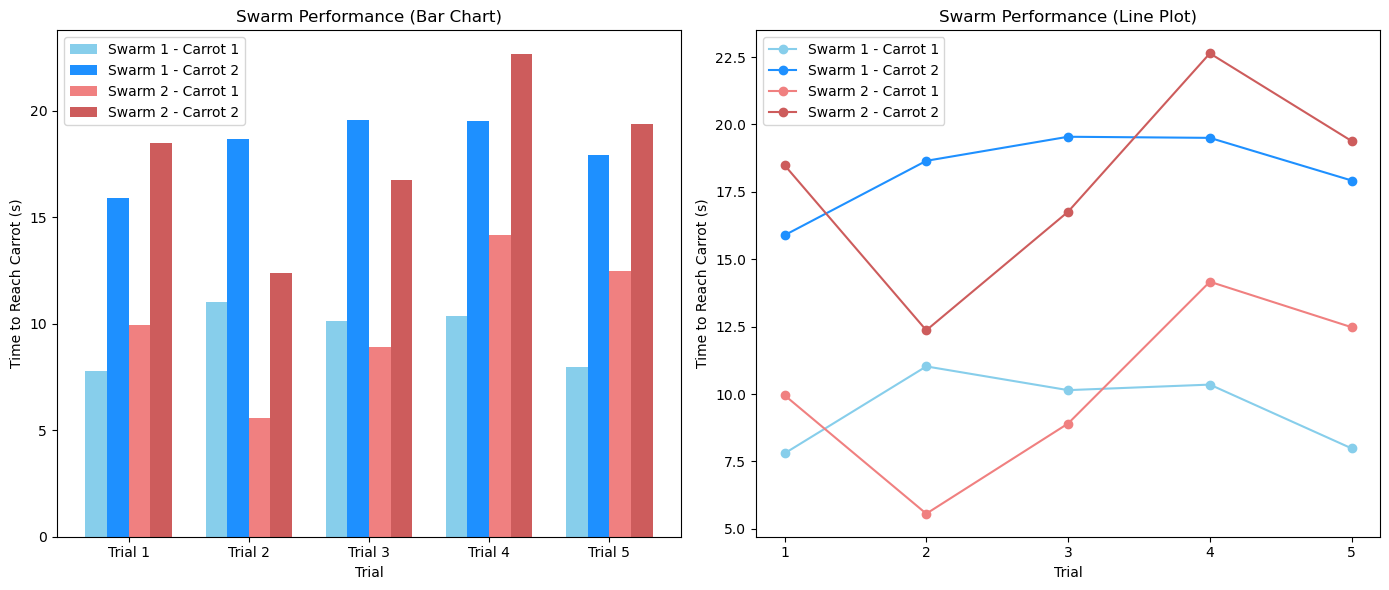

In [16]:
trials = np.arange(1, TRIALS + 1)

# Extract data
boids1_carrot1 = results["boids1_carrot1"]
boids1_carrot2 = results["boids1_carrot2"]
boids2_carrot1 = results["boids2_carrot1"]
boids2_carrot2 = results["boids2_carrot2"]

# Setup figure with two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ---- Grouped Bar Chart ----
width = 0.18

x = np.arange(TRIALS)
ax1.bar(x - 1.5 * width, boids1_carrot1, width, label='Swarm 1 - Carrot 1', color='skyblue')
ax1.bar(x - 0.5 * width, boids1_carrot2, width, label='Swarm 1 - Carrot 2', color='dodgerblue')
ax1.bar(x + 0.5 * width, boids2_carrot1, width, label='Swarm 2 - Carrot 1', color='lightcoral')
ax1.bar(x + 1.5 * width, boids2_carrot2, width, label='Swarm 2 - Carrot 2', color='indianred')

ax1.set_title("Swarm Performance (Bar Chart)")
ax1.set_xlabel("Trial")
ax1.set_ylabel("Time to Reach Carrot (s)")
ax1.set_xticks(x)
ax1.set_xticklabels([f"Trial {i}" for i in trials])
ax1.legend()

# ---- Line Plot ----
ax2.plot(trials, boids1_carrot1, marker='o', label='Swarm 1 - Carrot 1', color='skyblue')
ax2.plot(trials, boids1_carrot2, marker='o', label='Swarm 1 - Carrot 2', color='dodgerblue')
ax2.plot(trials, boids2_carrot1, marker='o', label='Swarm 2 - Carrot 1', color='lightcoral')
ax2.plot(trials, boids2_carrot2, marker='o', label='Swarm 2 - Carrot 2', color='indianred')

ax2.set_title("Swarm Performance (Line Plot)")
ax2.set_xlabel("Trial")
ax2.set_ylabel("Time to Reach Carrot (s)")
ax2.set_xticks(trials)
ax2.legend()

plt.tight_layout()
plt.show()



It can be seen that carrot 2 is on average harder to reach.